# SIEM-lite Performance Analysis

This notebook analyzes the results from SIEM-lite experiments.

**Contents:**
1. Load Experiment Data
2. Throughput Analysis
3. Latency Analysis
4. Scalability Analysis
5. Resource Utilization
6. Bottleneck Identification
7. Summary Report

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import glob
import os
from pathlib import Path

sns.set_style('whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)

# Directories
RESULTS_DIR = '../results'
PLOTS_DIR = f'{RESULTS_DIR}/plots'
Path(PLOTS_DIR).mkdir(parents=True, exist_ok=True)

## 1. Load Experiment Data

In [11]:
# Find all metrics files
# metrics_files = glob.glob(f'{RESULTS_DIR}/metrics_*.csv')
metrics_files = glob.glob(f'{RESULTS_DIR}/*.csv')
print(f'Found {len(metrics_files)} experiment results')

# Load all metrics
all_metrics = []
for f in metrics_files:
    # Parse filename: metrics_w{W}_r{R}_b{B}.csv
    parts = Path(f).stem.replace('metrics_', '').split('_')
    try:
        workers = int(parts[0][1:])
        rate = int(parts[1][1:])
        batch = int(parts[2][1:])
    except Exception:
        # skip malformed filenames
        continue

    try:
        df = pd.read_csv(f)
        if not df.empty:
            df['workers'] = workers
            df['rate'] = rate
            df['batch'] = batch
            df['exp_id'] = f'w{workers}_r{rate}_b{batch}'
            all_metrics.append(df)
    except Exception as e:
        print(f"Error reading {f}: {e}")

# Safely concat
if all_metrics:
    metrics_df = pd.concat(all_metrics, ignore_index=True)
    print(f"Loaded {len(metrics_df)} data points across {len(all_metrics)} experiments")
    display(metrics_df.head())
else:
    metrics_df = pd.DataFrame()
    print("No metrics data available")

Found 13 experiment results
Loaded 20 data points across 7 experiments


,timestamp,runtime_sec,events_processed,ingestion_queue_size,parsed_queue_size,cpu_percent,memory_mb,throughput_eps,alerts_count,workers,rate,batch,exp_id
0,2025-12-11T03:12:02.852135,5.0,0,0,0,0.0,26.1,0.0,49,1,200,100,w1_r200_b100
1,2025-12-11T03:12:07.955580,10.2,0,0,0,0.0,26.2,0.0,49,1,200,100,w1_r200_b100
2,2025-12-11T03:11:50.639943,5.0,0,0,0,0.0,26.4,0.0,91,1,200,50,w1_r200_b50
3,2025-12-11T03:11:55.742673,10.2,0,0,0,0.0,26.5,0.0,91,1,200,50,w1_r200_b50
4,2025-12-11T03:12:27.575928,5.0,0,0,0,0.0,26.6,0.0,329,1,500,100,w1_r500_b100


## 2. Throughput Analysis

In [3]:
# Calculate steady-state throughput (last 50% of each run)
steady_state = []
if not metrics_df.empty:
    for exp_id in metrics_df['exp_id'].unique():
        exp_data = metrics_df[metrics_df['exp_id'] == exp_id]
        if len(exp_data) > 2:
            mid = len(exp_data) // 2
            steady = exp_data.iloc[mid:]
            steady_state.append({
                'exp_id': exp_id,
                'workers': exp_data['workers'].iloc[0],
                'rate': exp_data['rate'].iloc[0],
                'batch': exp_data['batch'].iloc[0],
                'avg_throughput': steady.get('throughput_eps', pd.Series([0])).mean(),
                'max_throughput': steady.get('throughput_eps', pd.Series([0])).max(),
                'avg_cpu': steady.get('cpu_percent', pd.Series([0])).mean(),
                'avg_memory': steady.get('memory_mb', pd.Series([0])).mean()
            })
    if steady_state:
        ss_df = pd.DataFrame(steady_state)
        print('Top 10 configurations by throughput:')
        display(ss_df.nlargest(10, 'avg_throughput')[['exp_id', 'avg_throughput', 'workers', 'batch']])
    else:
        ss_df = pd.DataFrame()
else:
    ss_df = pd.DataFrame()
    print('No metrics available')

Top 10 configurations by throughput:


,exp_id,avg_throughput,workers,batch
0,w2_r300_b100,0.0,2,100


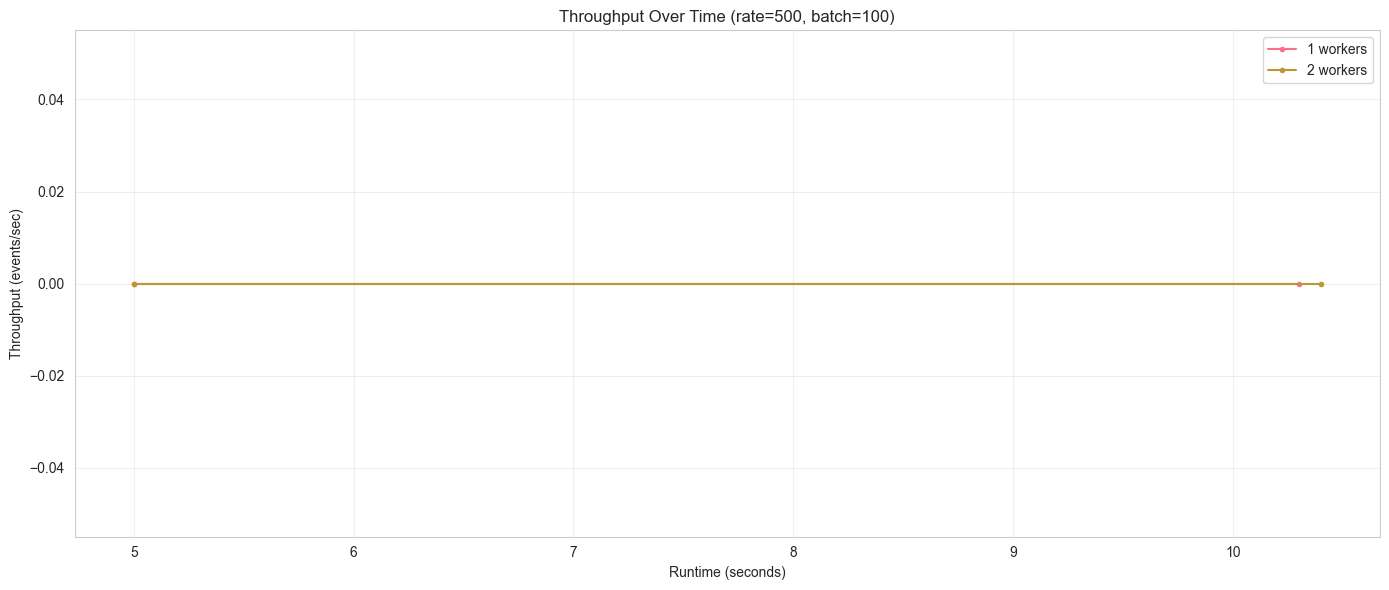

In [4]:
# Plot throughput over time
if not metrics_df.empty:
    fig, ax = plt.subplots(figsize=(14, 6))
    # Select a common rate/batch to compare workers
    target_rate = metrics_df['rate'].max()
    target_batch = metrics_df['batch'].max()
    
    # If max wasn't run, pick the most common one
    if metrics_df[metrics_df['rate'] == target_rate].empty:
         target_rate = metrics_df['rate'].mode()[0]
         
    workers_list = sorted(metrics_df['workers'].unique())
    
    for workers in workers_list:
        subset = metrics_df[
            (metrics_df['workers'] == workers) &
            (metrics_df['rate'] == target_rate)
        ]
        # If multiple batches, pick one
        if not subset.empty:
            # Prefer the target batch
            if target_batch in subset['batch'].values:
                subset = subset[subset['batch'] == target_batch]
            else:
                 # fallback
                 b = subset['batch'].iloc[0]
                 subset = subset[subset['batch'] == b]
            
            ax.plot(subset['runtime_sec'], subset['throughput_eps'], marker='.', label=f'{workers} workers')

    ax.set_xlabel('Runtime (seconds)')
    ax.set_ylabel('Throughput (events/sec)')
    ax.set_title(f'Throughput Over Time (rate={target_rate}, batch={target_batch})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{PLOTS_DIR}/throughput_over_time.png', dpi=300)
    plt.show()
else:
    print('No metrics to plot')

## 3. Latency Analysis

Processing w1_r200_b100...
Processing w1_r200_b50...
Processing w1_r500_b100...
Processing w1_r500_b50...
Processing w2_r200_b50...
Processing w2_r300_b100...
Processing w2_r500_b50...


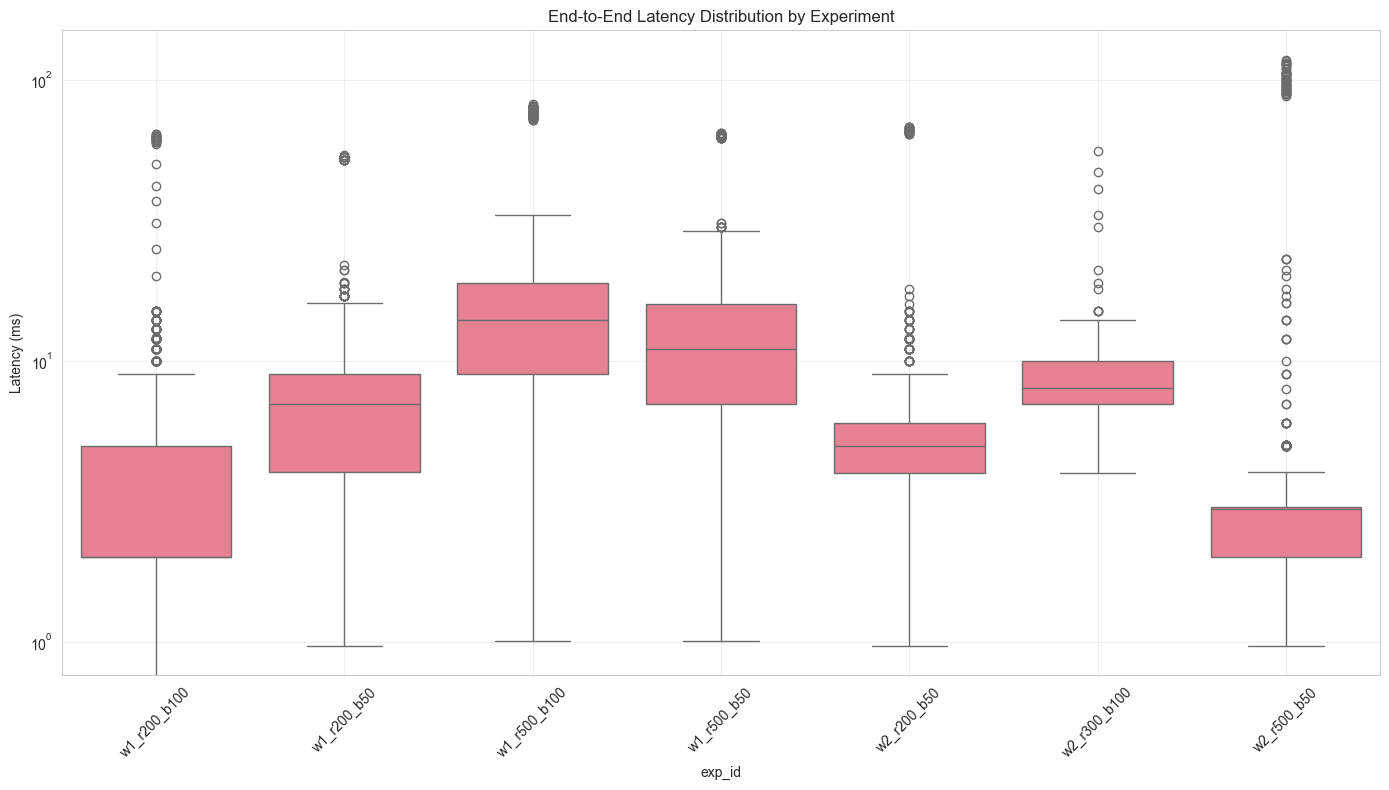

Latency Summary (ms):


,count,mean,std,min,50%,90%,95%,99%,max
exp_id,,,,,,,,,
w1_r200_b100,2300.0,4.412648,6.404322,0.000000,2.011657,9.012222,11.989474,31.039864,64.010918
w1_r200_b50,800.0,8.382373,7.983944,0.965595,7.000566,12.999326,17.018616,52.987039,53.992867
w1_r500_b100,1700.0,15.654192,12.448152,1.005828,14.001131,24.019182,26.996434,78.012049,81.995130
w1_r500_b50,3600.0,12.368504,8.634827,1.005828,10.983646,21.967292,24.984777,63.005090,64.976513
w2_r200_b50,800.0,6.681919,9.866625,0.965595,4.988909,9.012222,12.995303,66.032231,67.993999
w2_r300_b100,1472.0,8.652967,3.007653,3.983080,8.006394,11.989474,12.029707,14.001131,56.004524
w2_r500_b50,1800.0,5.494997,16.192560,0.965595,2.977252,4.023314,4.990920,103.046715,118.003786


In [5]:
# Load latencies from SQLite databases
latency_data = []

if not metrics_df.empty:
    unique_experiments = metrics_df[['exp_id', 'workers', 'rate', 'batch']].drop_duplicates()

    for _, row in unique_experiments.iterrows():
        exp_id = row['exp_id']
        print(f"Processing {exp_id}...")
        db_path = f"{RESULTS_DIR}/events_{exp_id}.db"
        
        if os.path.exists(db_path):
            try:
                conn = sqlite3.connect(db_path)
                # Calculate latency (indexed_at - ingested_at) in ms
                # SQLite julianday returns days, so multiply by 24*60*60*1000 = 86400000
                query = """
                    SELECT (julianday(indexed_at) - julianday(ingested_at)) * 86400000 as latency_ms 
                    FROM events 
                    WHERE indexed_at IS NOT NULL AND ingested_at IS NOT NULL
                """
                # Read in chunks or limit if too large, but for analysis usually fine to read all
                lats = pd.read_sql_query(query, conn)
                conn.close()
                
                if not lats.empty:
                    # Sample if too huge (e.g. > 100k points)
                    if len(lats) > 10000:
                        lats = lats.sample(10000)
                    
                    lats['exp_id'] = exp_id
                    lats['workers'] = row['workers']
                    lats['rate'] = row['rate']
                    latency_data.append(lats)
            except Exception as e:
                print(f"Failed to read {db_path}: {e}")
        else:
            print(f"Database not found: {db_path}")

    if latency_data:
        latency_df = pd.concat(latency_data, ignore_index=True)
        
        # Plot Boxplot
        plt.figure(figsize=(14, 8))
        sns.boxplot(x='exp_id', y='latency_ms', data=latency_df)
        plt.xticks(rotation=45)
        plt.title('End-to-End Latency Distribution by Experiment')
        plt.ylabel('Latency (ms)')
        plt.yscale('log')  # Log scale often helps with latency
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{PLOTS_DIR}/latency_distribution.png', dpi=300)
        plt.show()
        
        # Latency Summary Table
        lat_summary = latency_df.groupby('exp_id')['latency_ms'].describe(percentiles=[0.5, 0.9, 0.95, 0.99])
        print("Latency Summary (ms):")
        display(lat_summary)
    else:
        print("No latency data extracted")
else:
    print("No experiments to analyze")

## 4. Scalability Analysis

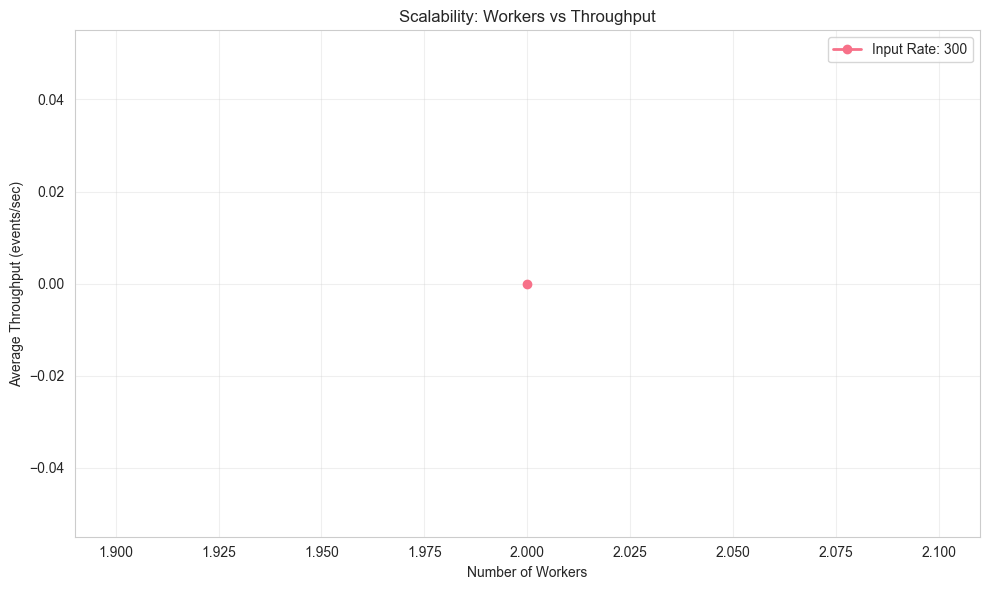

In [6]:
# Workers vs throughput (grouped by rate)
if not ss_df.empty:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    rates = sorted(ss_df['rate'].unique())
    for rate in rates:
        subset = ss_df[ss_df['rate'] == rate]
        # Average across batches for the same rate/workers
        subset = subset.groupby('workers')['avg_throughput'].mean()
        ax.plot(subset.index, subset.values, marker='o', linewidth=2, label=f'Input Rate: {rate}')

    # Add ideal linear scaling line (based on first point of highest rate)
    max_rate = max(rates)
    base_subset = ss_df[(ss_df['rate'] == max_rate) & (ss_df['workers'] == 1)]
    if not base_subset.empty:
        base_tp = base_subset['avg_throughput'].mean()
        workers_range = sorted(ss_df['workers'].unique())
        ideal = [base_tp * w for w in workers_range]
        ax.plot(workers_range, ideal, 'k--', alpha=0.5, label='Ideal Linear Scaling')

    ax.set_xlabel('Number of Workers')
    ax.set_ylabel('Average Throughput (events/sec)')
    ax.set_title('Scalability: Workers vs Throughput')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{PLOTS_DIR}/scalability.png', dpi=300)
    plt.show()
else:
    print('No steady-state data available')

## 5. Resource Utilization

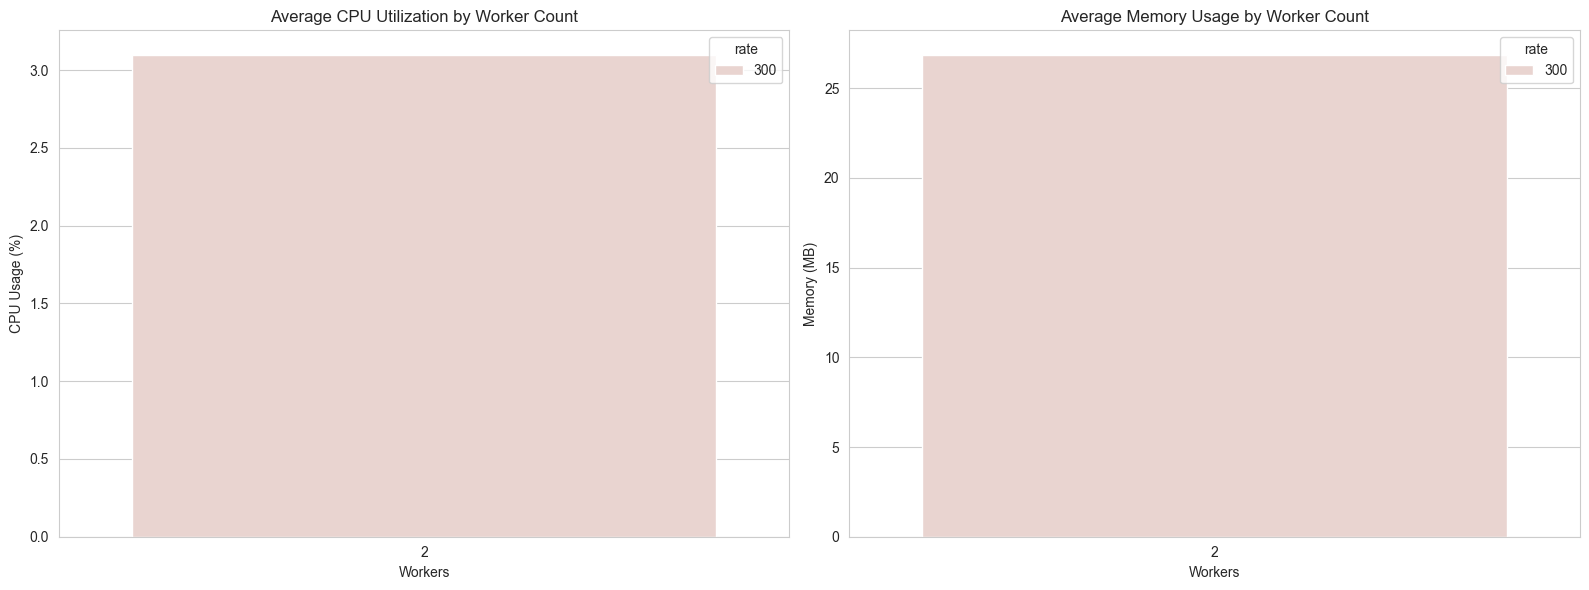

In [7]:
if not ss_df.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # CPU Utilization
    sns.barplot(x='workers', y='avg_cpu', hue='rate', data=ss_df, ax=ax1)
    ax1.set_title('Average CPU Utilization by Worker Count')
    ax1.set_ylabel('CPU Usage (%)')
    ax1.set_xlabel('Workers')

    # Memory Utilization
    sns.barplot(x='workers', y='avg_memory', hue='rate', data=ss_df, ax=ax2)
    ax2.set_title('Average Memory Usage by Worker Count')
    ax2.set_ylabel('Memory (MB)')
    ax2.set_xlabel('Workers')
    
    plt.tight_layout()
    plt.savefig(f'{PLOTS_DIR}/resource_utilization.png', dpi=300)
    plt.show()
else:
    print("No resource data available")

## 6. Bottleneck Identification
Analyzing queue sizes to identify backpressure.

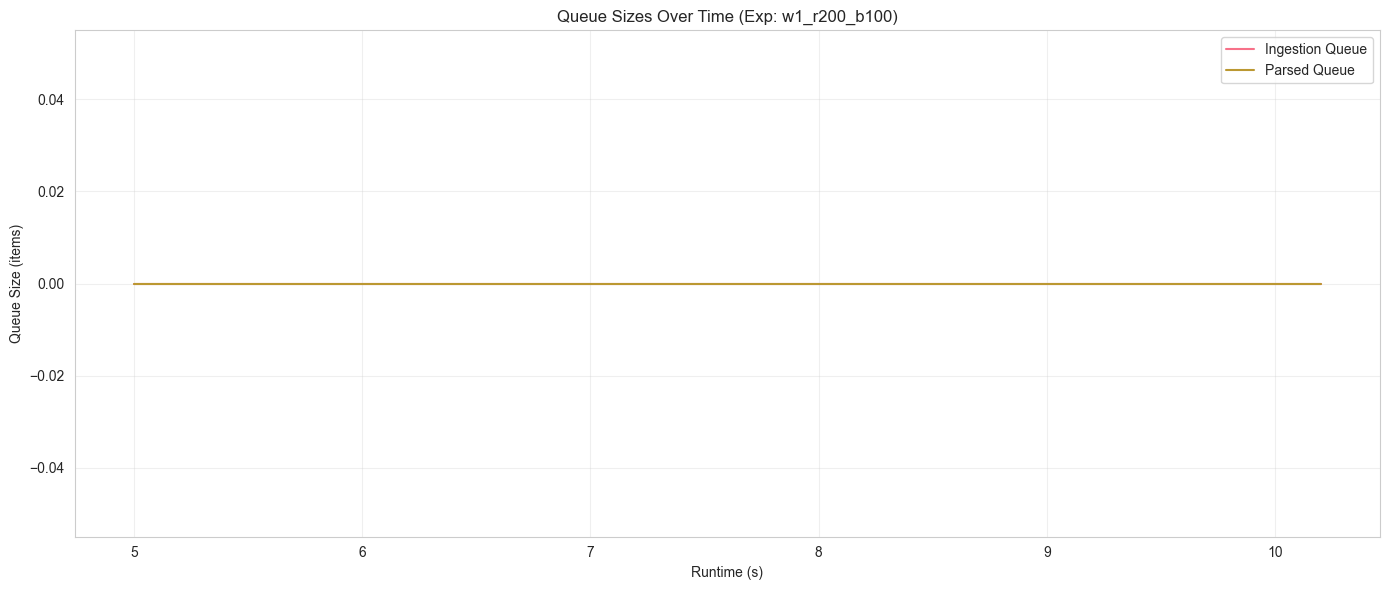

Analyzed queues for experiment: w1_r200_b100
Note: High Ingestion Queue = Parser Bottleneck. High Parsed Queue = Indexer/DB Bottleneck.


In [8]:
if not metrics_df.empty:
    # Pick the experiment with the highest throughput (or valid one)
    best_exp_id = metrics_df.loc[metrics_df['throughput_eps'].idxmax()]['exp_id'] if not metrics_df['throughput_eps'].isna().all() else metrics_df['exp_id'].iloc[0]
    
    subset = metrics_df[metrics_df['exp_id'] == best_exp_id]
    
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(subset['runtime_sec'], subset['ingestion_queue_size'], label='Ingestion Queue')
    ax.plot(subset['runtime_sec'], subset['parsed_queue_size'], label='Parsed Queue')
    
    ax.set_title(f'Queue Sizes Over Time (Exp: {best_exp_id})')
    ax.set_ylabel('Queue Size (items)')
    ax.set_xlabel('Runtime (s)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{PLOTS_DIR}/queue_backpressure.png', dpi=300)
    plt.show()
    
    print(f"Analyzed queues for experiment: {best_exp_id}")
    print("Note: High Ingestion Queue = Parser Bottleneck. High Parsed Queue = Indexer/DB Bottleneck.")
else:
    print("No metrics available")

## 7. Summary Report

In [9]:
print('='*60)
print('SIEM-LITE PERFORMANCE SUMMARY')
print('='*60)

if not ss_df.empty:
    print(f'\nTotal experiments: {len(ss_df)}')
    
    print('\n📊 Throughput:')
    peak_tp = ss_df["avg_throughput"].max()
    print(f'  Peak: {peak_tp:.0f} events/sec')
    best_config = ss_df.loc[ss_df['avg_throughput'].idxmax()]
    print(f'  Best config: Workers={best_config["workers"]}, Rate={best_config["rate"]}, Batch={best_config["batch"]}')
    
    print('\n🔧 Resource Usage:')
    print(f'  Avg CPU: {ss_df["avg_cpu"].mean():.1f}%')
    print(f'  Avg Memory: {ss_df["avg_memory"].mean():.0f} MB')
    
    if 'latency_df' in locals() and not latency_df.empty:
        print('\n⏱️ Latency (Global Stats):')
        print(f'  Avg: {latency_df["latency_ms"].mean():.1f} ms')
        print(f'  P99: {latency_df["latency_ms"].quantile(0.99):.1f} ms')
else:
    print('No data available to summarize')

print('\n' + '='*60)

SIEM-LITE PERFORMANCE SUMMARY

Total experiments: 1

📊 Throughput:
  Peak: 0 events/sec
  Best config: Workers=2, Rate=300, Batch=100

🔧 Resource Usage:
  Avg CPU: 3.1%
  Avg Memory: 27 MB

⏱️ Latency (Global Stats):
  Avg: 9.3 ms
  P99: 64.0 ms

